In [40]:
%pip install pandas matplotlib seaborn

import glob
import json

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas import DataFrame


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
Note: you may need to restart the kernel to use updated packages.


In [41]:
def analyze_watermarking_data(json_path_pattern: str) -> None:
    """
    Analizuje dane z plików JSON w podanej strukturze i wizualizuje wyniki.

    Args:
        json_path_pattern (str): Wzorzec ścieżki do plików JSON (np. "/path/to/*.json").
    """
    # Wczytaj dane z plików JSON
    json_files = glob.glob(json_path_pattern)
    data = []

    for _, file in enumerate(json_files):
        with open(file, "r") as f:
            try:
                json_data = json.load(f)
                if isinstance(json_data, list):
                    data.extend(json_data)
                else:
                    data.append(json_data)
            except json.JSONDecodeError:
                print(f"Error reading file: {file}")
                continue

    # Jeśli brak danych, zakończ
    if not data:
        print("No valid JSON data found.")
        return

    # Normalizacja do DataFrame
    df = pd.json_normalize(data)

    # Podstawowa analiza danych
    print("Basic Overview:")
    print(df.info())
    print(df.head())

    # Agregacja wyników
    analysis_columns = [
        "watermarked_analysis_results.PSNR",
        "watermarked_analysis_results.Mean Squared Error",
        "watermarked_analysis_results.Entropy",
        "watermarked_analysis_results.Average Pixel Error",
        "watermarked_analysis_results.LPIPS Loss",
        "watermarked_analysis_results.QualiCLIP_original",
        "watermarked_analysis_results.QualiCLIP_watermarked",
        "watermark_method",
        "attack_method",
        "encoding_time",
        "decoding_time",
    ]

    df_filtered = df[analysis_columns].copy()
    df_filtered.columns = [col.split(".")[-1] for col in df_filtered.columns]

    # Usuwanie wartości NaN i zamiana "Infinity" na NaN
    df_filtered = df_filtered.replace("Infinity", None).dropna()

    numeric_columns = [
        "PSNR",
        "Mean Squared Error",
        "Entropy",
        "Average Pixel Error",
        "LPIPS Loss",
        "QualiCLIP_original",
        "QualiCLIP_watermarked",
        "encoding_time",
        "decoding_time",
    ]
    df_filtered[numeric_columns] = df_filtered[numeric_columns].apply(
        pd.to_numeric, errors="coerce"
    )

    # Analiza odporności (robustness)
    df_filtered["Robustness"] = df_filtered["PSNR"] / (
        df_filtered["Mean Squared Error"] + 1e-10
    )

    # Analiza odporności 2 (robustness)
    analyze_robustness_by_watermark_method(df_filtered)

    # Analiza czasów kodowania i dekodowania
    df_filtered["Total_time"] = df_filtered["encoding_time"] + df_filtered[
        "decoding_time"
    ].fillna(0)

    df_filtered["Quality_diff"] = abs(
        df_filtered["QualiCLIP_original"] - df_filtered["QualiCLIP_watermarked"]
    )

    # Wizualizacja wyników
    print("Summary Statistics:", df_filtered.describe())

    # Wykresy
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_filtered, x="watermark_method", y="PSNR")
    plt.title("PSNR by Watermarking Method")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_filtered, x="attack_method", y="Mean Squared Error")
    plt.title("Mean Squared Error by Attack Method")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_filtered, x="attack_method", y="Robustness")
    plt.title("Robustness by Attack Method")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_filtered, x="watermark_method", y="Total_time", ci="sd")
    plt.title("Total Encoding/Decoding Time by Watermarking Method")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_filtered, x="watermark_method", y="encoding_time", ci="sd")
    plt.title("Encoding Time by Watermarking Method")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df_filtered, x="PSNR", y="LPIPS Loss", hue="attack_method")
    plt.title("PSNR vs LPIPS Loss with Attack Method")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        data=df_filtered, x="Entropy", y="Average Pixel Error", hue="watermark_method"
    )
    plt.title("Entropy vs Average Pixel Error by Watermarking Method")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_filtered, x="attack_method", y="LPIPS Loss", ci="sd")
    plt.title("LPIPS Loss by Attack Method")
    plt.xticks(rotation=45)
    plt.show()

    # Wizualizacja czasu vs odporności
    plt.figure(figsize=(12, 6))
    sns.scatterplot(
        data=df_filtered,
        x="Total_time",
        y="Robustness",
        hue="watermark_method",
        style="attack_method",
    )
    plt.title("Total Encoding/Decoding Time vs Robustness")
    plt.xlabel("Total Time (Encoding + Decoding)")
    plt.ylabel("Robustness (PSNR / MSE)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

    # Analiza jakości obrazu
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=df_filtered,
        x="watermark_method",
        y="Quality_diff",
        ci="sd",
        palette="coolwarm",
    )
    plt.title("Quality Difference (QualiCLIP) by Watermarking Method")
    plt.xlabel("Watermark Method")
    plt.ylabel("Quality Difference")
    plt.xticks(rotation=45)
    plt.show()

    # Korelacja między metrykami
    correlation_matrix = df_filtered[numeric_columns].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Metrics")
    plt.show()

    # Wpływ ataku na LPIPS Loss
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=df_filtered, x="attack_method", y="LPIPS Loss", hue="watermark_method"
    )
    plt.title("LPIPS Loss by Attack Method and Watermarking Method")
    plt.xlabel("Attack Method")
    plt.ylabel("LPIPS Loss")
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()


def analyze_robustness_by_watermark_method(df_filtered: DataFrame) -> None:
    """
    Analizuje odporność na ataki (robustness) dla różnych metod znakowania wodnego.

    Args:
        df_filtered (pd.DataFrame): Przefiltrowany DataFrame zawierający odpowiednie metryki.
    """
    # Grupowanie danych i obliczanie średniej odporności dla każdej metody znakowania
    robustness_summary = (
        df_filtered.groupby("watermark_method")["Robustness"]
        .mean()
        .sort_values(ascending=False)
    )
    print("Average Robustness by Watermark Method:", robustness_summary)

    # Wizualizacja odporności dla każdej metody znakowania
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=robustness_summary.index, y=robustness_summary.values, palette="viridis"
    )
    plt.title("Average Robustness by Watermark Method")
    plt.xlabel("Watermark Method")
    plt.ylabel("Average Robustness (PSNR / MSE)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Wizualizacja jakości PSNR vs czas kodowania
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df_filtered, x="encoding_time", y="PSNR", hue="attack_method")
    plt.title("PSNR vs Encoding Time by Attack Method")
    plt.xlabel("Encoding Time")
    plt.ylabel("PSNR")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

Basic Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4095 entries, 0 to 4094
Data columns (total 24 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   filepath                                                         4095 non-null   object 
 1   attacked_analysis_results                                        2401 non-null   object 
 2   watermark_method                                                 4095 non-null   object 
 3   attack_method                                                    4095 non-null   object 
 4   encoding_time                                                    4095 non-null   float64
 5   decoding_time                                                    2151 non-null   float64
 6   watermarked_analysis_results.PSNR                                4095 non-null   float64
 7   watermarked_analysis_resul

/tmp/ipykernel_499284/2735979206.py:211: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


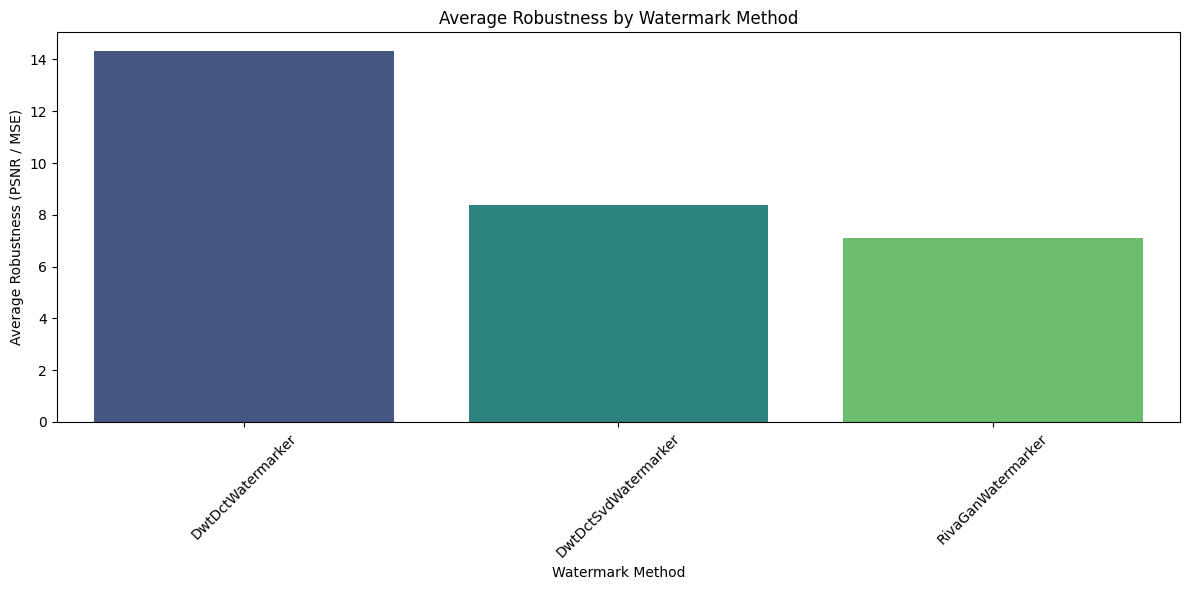

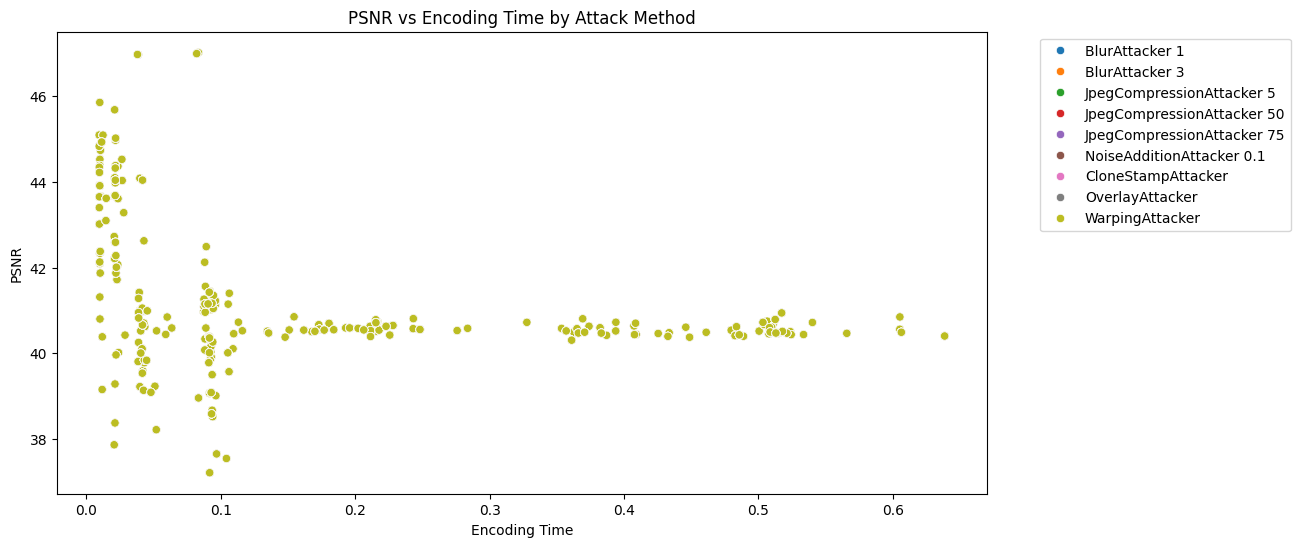

Summary Statistics:               PSNR  Mean Squared Error      Entropy  Average Pixel Error  \
count  2151.000000         2151.000000  2151.000000          2151.000000   
mean     41.177080            5.309638     7.409342            80.571415   
std       1.730572            1.778761     0.453316            36.345397   
min      37.210744            1.291808     5.571703             4.969504   
25%      40.424374            4.686964     7.225434            55.906695   
50%      40.597444            5.666775     7.526595            67.537959   
75%      41.421888            5.897161     7.735163           123.094080   
max      47.018825           12.359643     7.959909           133.085301   

        LPIPS Loss  QualiCLIP_original  QualiCLIP_watermarked  encoding_time  \
count  2151.000000         2151.000000            2151.000000    2151.000000   
mean      0.031836            0.800728               0.746526       0.169242   
std       0.025741            0.082595               0.

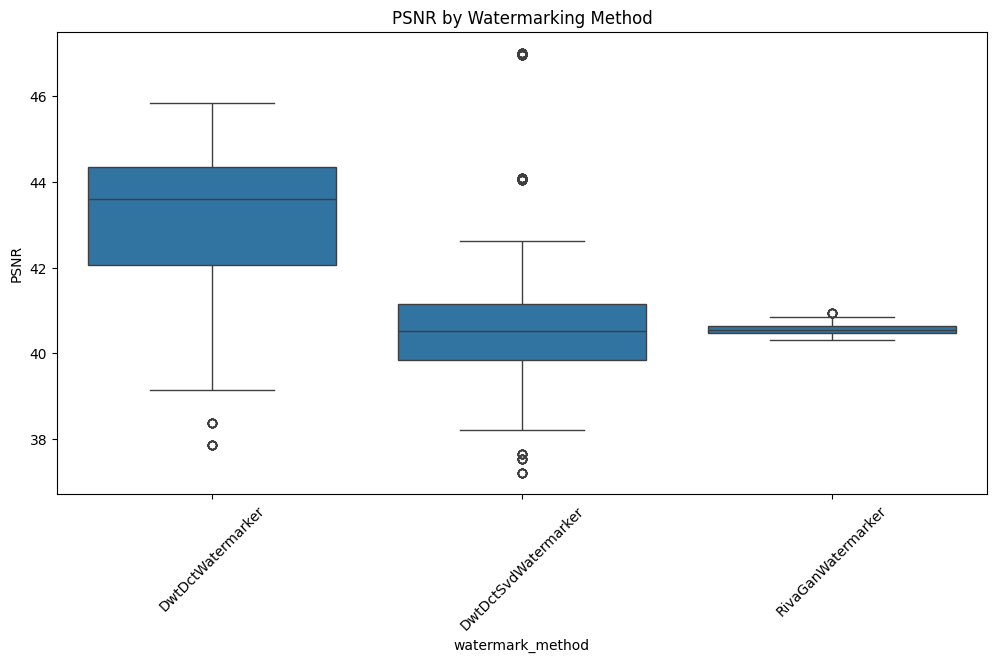

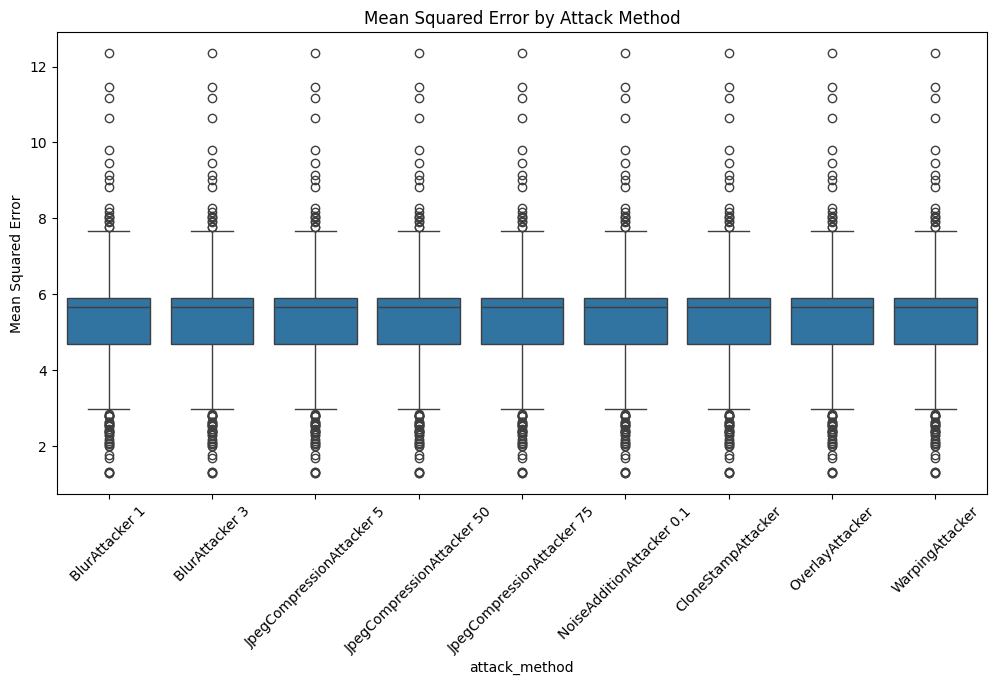

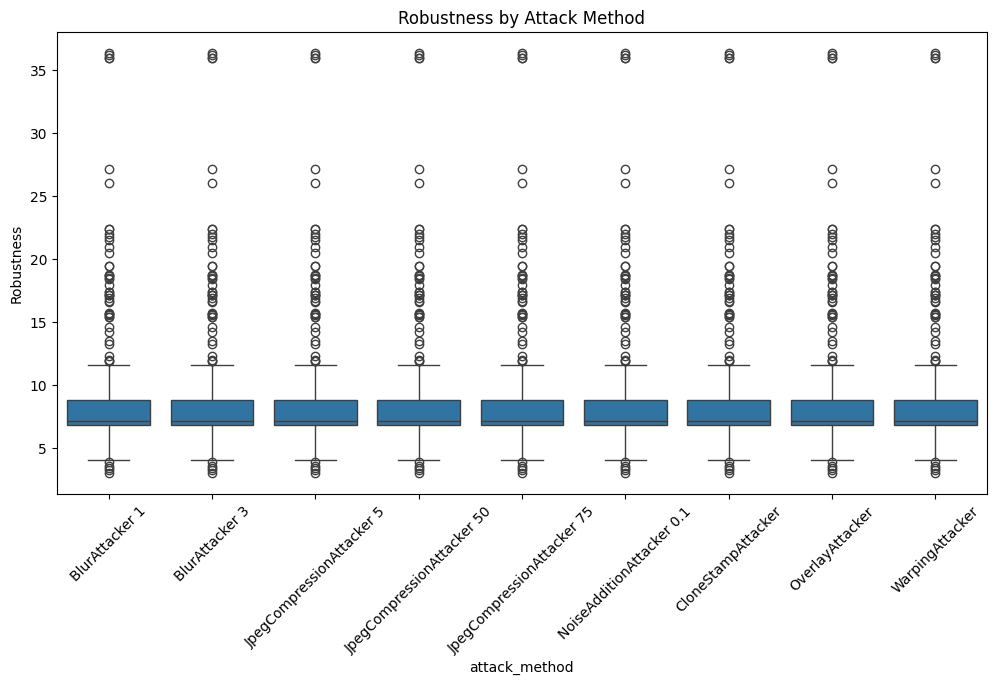

/tmp/ipykernel_499284/2735979206.py:113: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_filtered, x="watermark_method", y="Total_time", ci="sd")


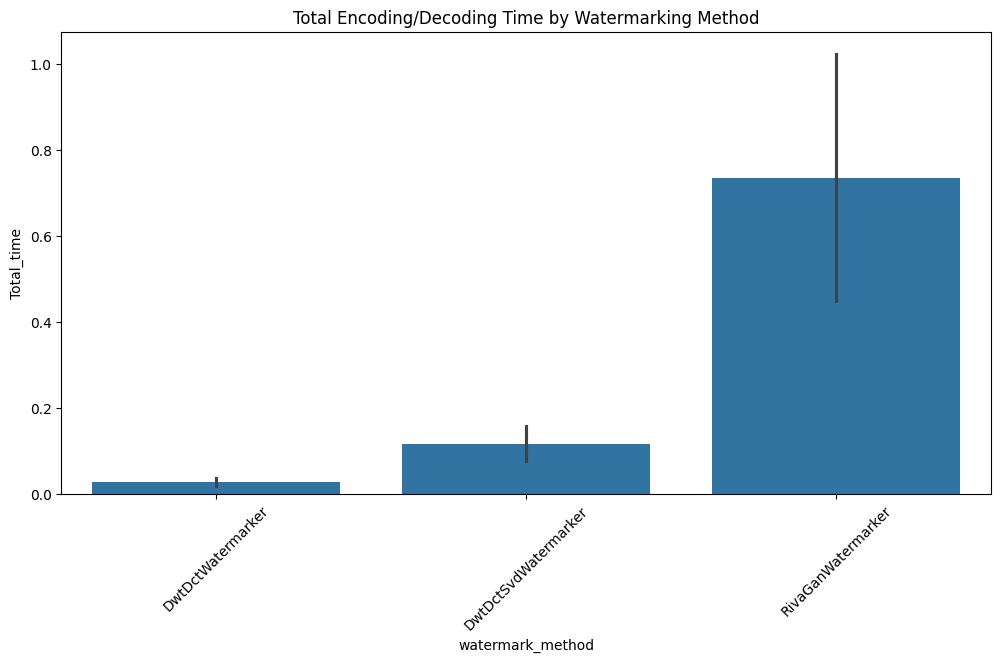

/tmp/ipykernel_499284/2735979206.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_filtered, x="watermark_method", y="encoding_time", ci="sd")


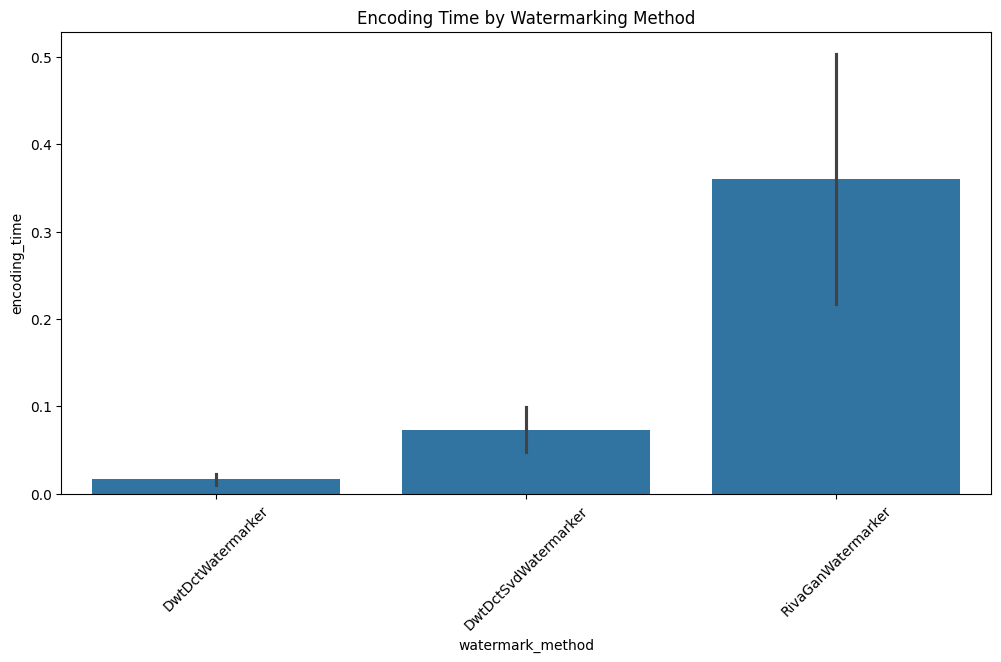

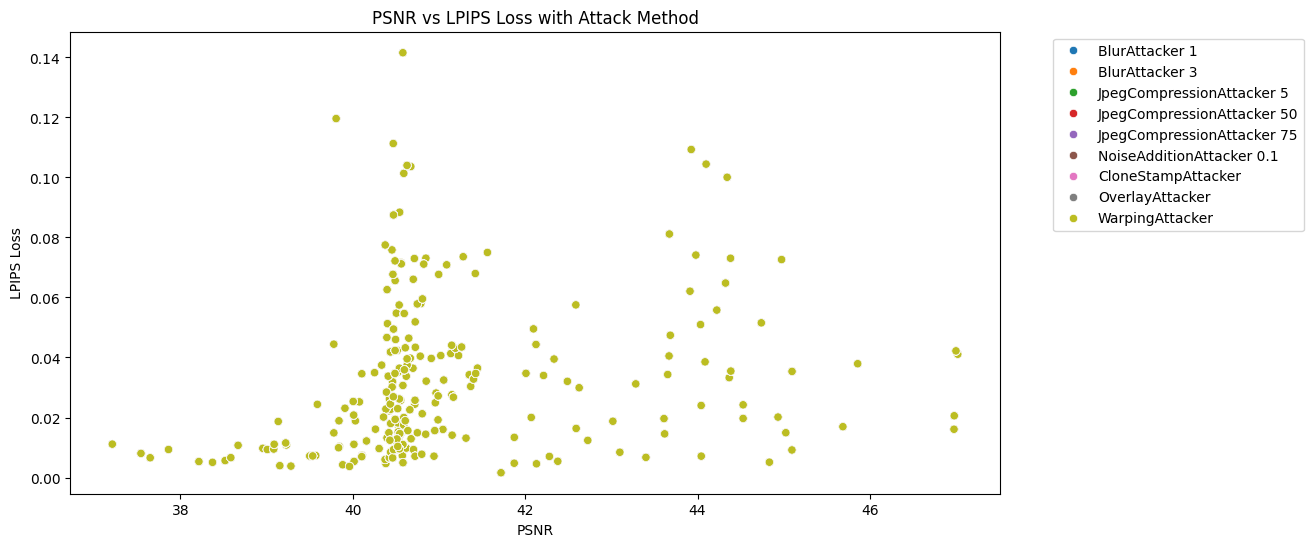

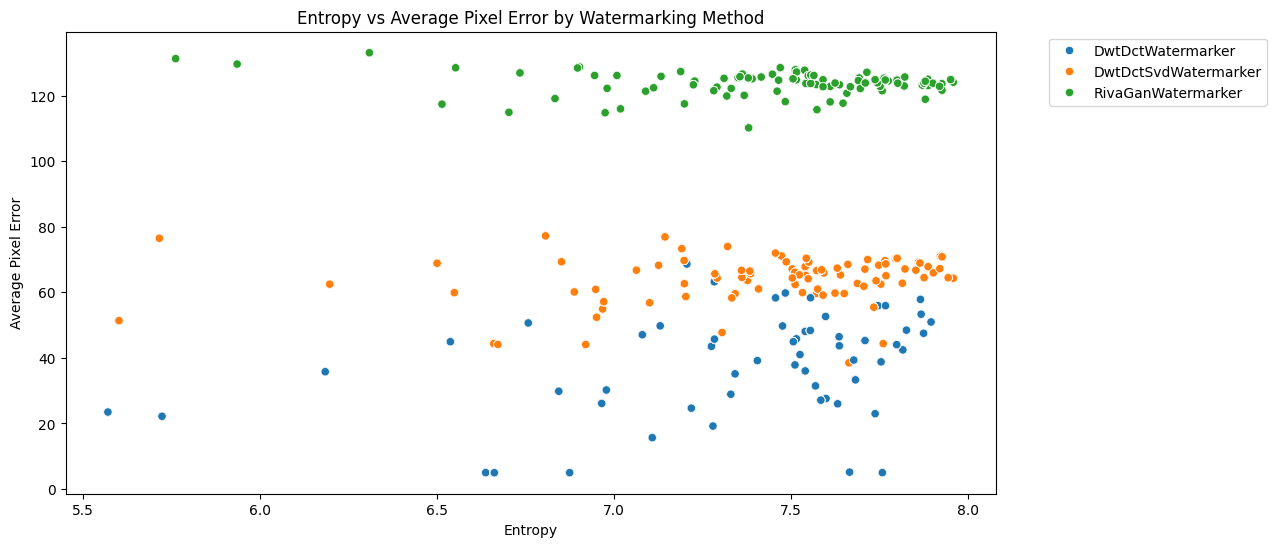

/tmp/ipykernel_499284/2735979206.py:139: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df_filtered, x="attack_method", y="LPIPS Loss", ci="sd")


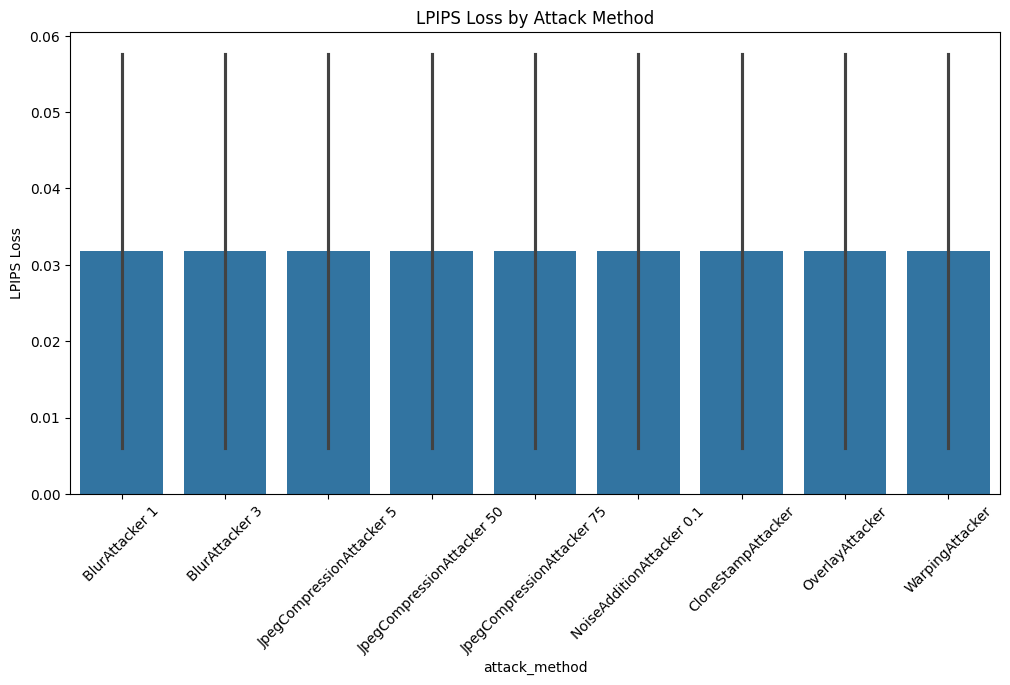

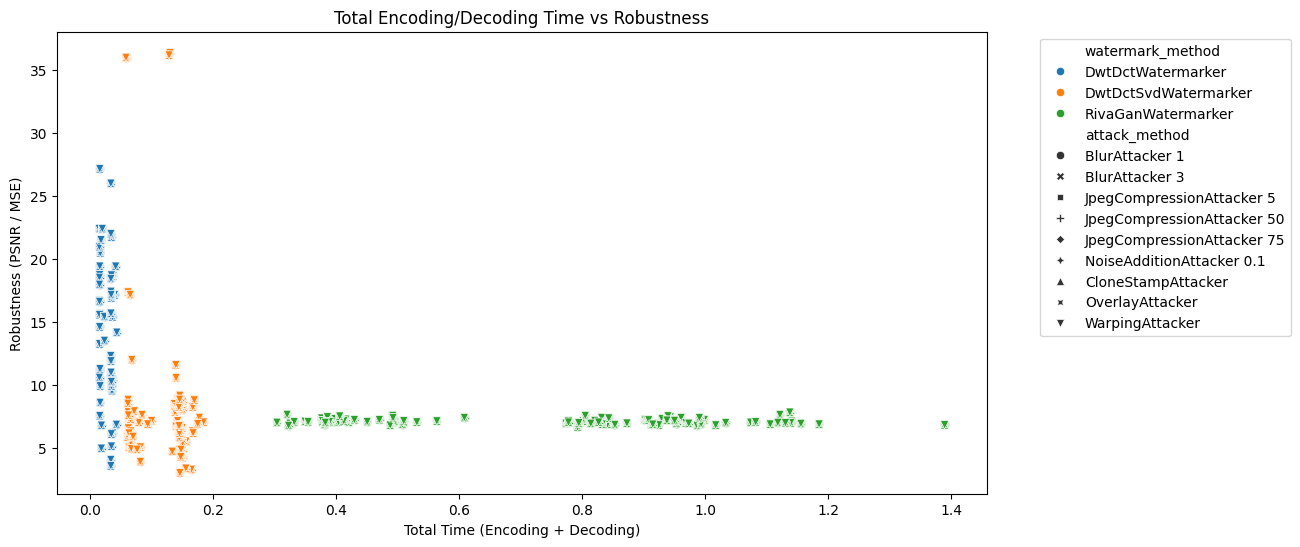

/tmp/ipykernel_499284/2735979206.py:161: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
/tmp/ipykernel_499284/2735979206.py:161: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


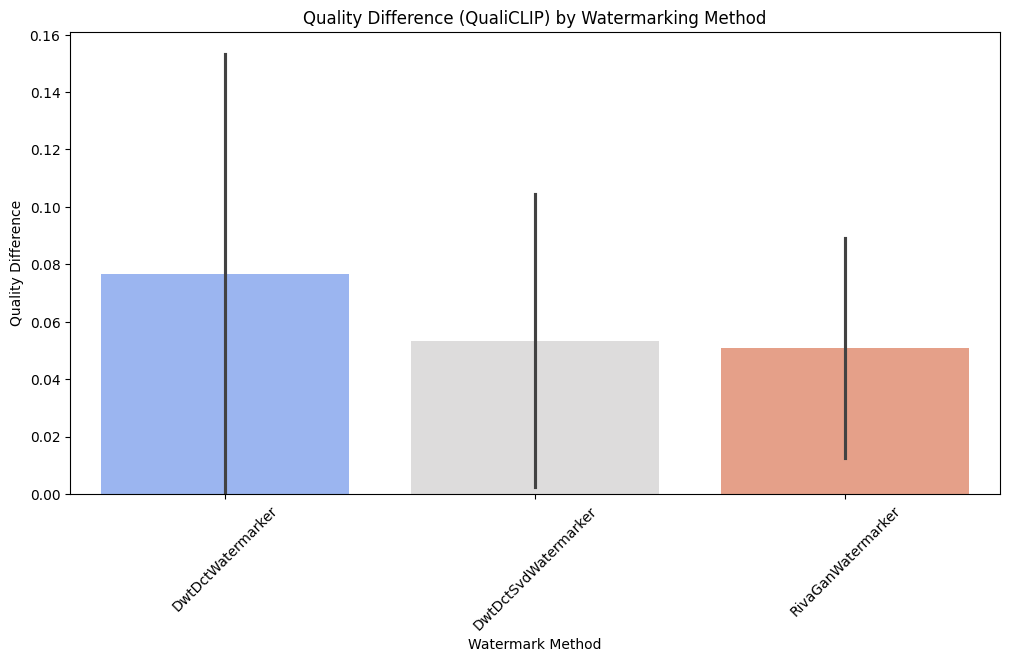

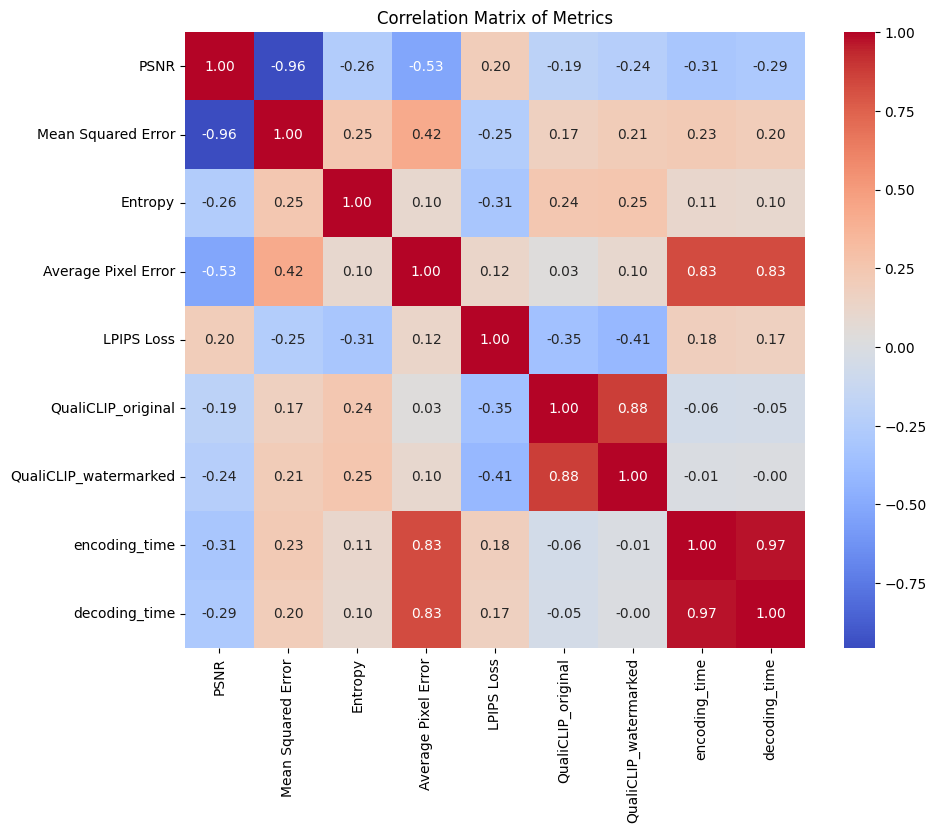

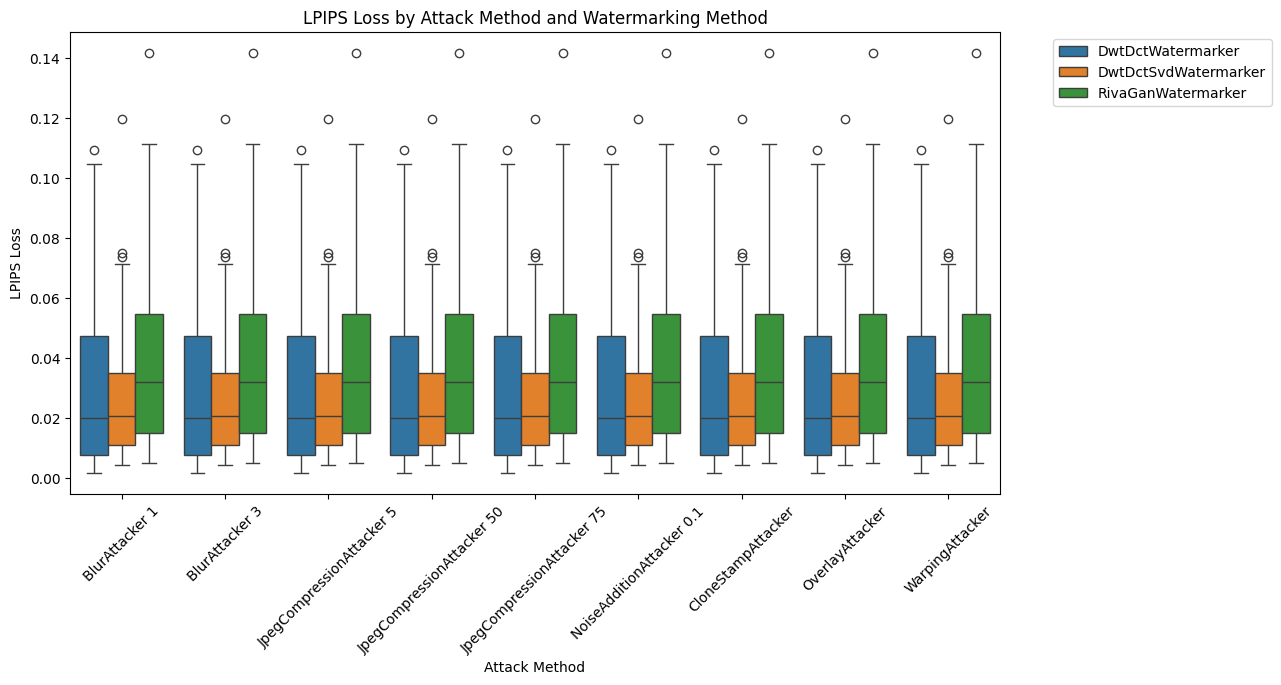

In [42]:
analyze_watermarking_data("./01-data/*.json")